In [ ]:
# Deep learning and YOLO
from ultralytics import YOLO
import torch

# File and data handling
from pathlib import Path
import yaml

# Visualization and image processing
import matplotlib.pyplot as plt
import cv2

# Utilities
import random 
import numpy as np

# Object Detection Training with YOLO

This notebook implements object detection training for the peatland navigation project using the YOLO (You Only Look Once) architecture. The model is trained to detect key objects in peatland environments:
- Benches
- Signs
- Navigation Markers

Key Features:
- YOLOv11-medium backbone for optimal speed/accuracy trade-off
- Integration of negative samples for improved robustness
- Custom dataset visualization tools
- Efficient training pipeline

## 1. Import Required Libraries

In [ ]:
# Dataset configuration paths
DATA_YAML_PATH = Path("../data/processed/detection/data.yaml")
NEGATIVE_IMAGES_DIR = Path("../data/video/frames/")

# Load and modify YAML configuration to include negative samples
with open(DATA_YAML_PATH, 'r') as f:
    data_yaml = yaml.safe_load(f)

# Append negative samples path if available
train_paths = [data_yaml['train']]
if NEGATIVE_IMAGES_DIR.exists():
    train_paths.append(str(NEGATIVE_IMAGES_DIR.resolve()))
    print(f"Found negative images folder. Adding it to the training set.")

# Create modified YAML with negative samples included
temp_yaml_path = Path("../data/processed/detection/data_with_negatives.yaml")
data_yaml['train'] = train_paths

with open(temp_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False, default_flow_style=False)

print(f"Temporary YAML with negative samples created at: {temp_yaml_path}")

# Training hyperparameters
NUM_EPOCHS = 10
IMAGE_SIZE = 640  # YOLO default input size
BATCH_SIZE = 8

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Found negative images folder. Adding it to the training set.
Temporary YAML with negative samples created at: ../data/processed/detection/data_with_negatives.yaml
Using device: mps


## 2. Configuration and Dataset Setup

This section handles:
1. Loading and modifying the dataset configuration
2. Integration of negative samples for robust training
3. Setting up training hyperparameters

The negative samples are crucial for reducing false positives in areas without objects of interest.

Visualizing samples for class: 'bench'


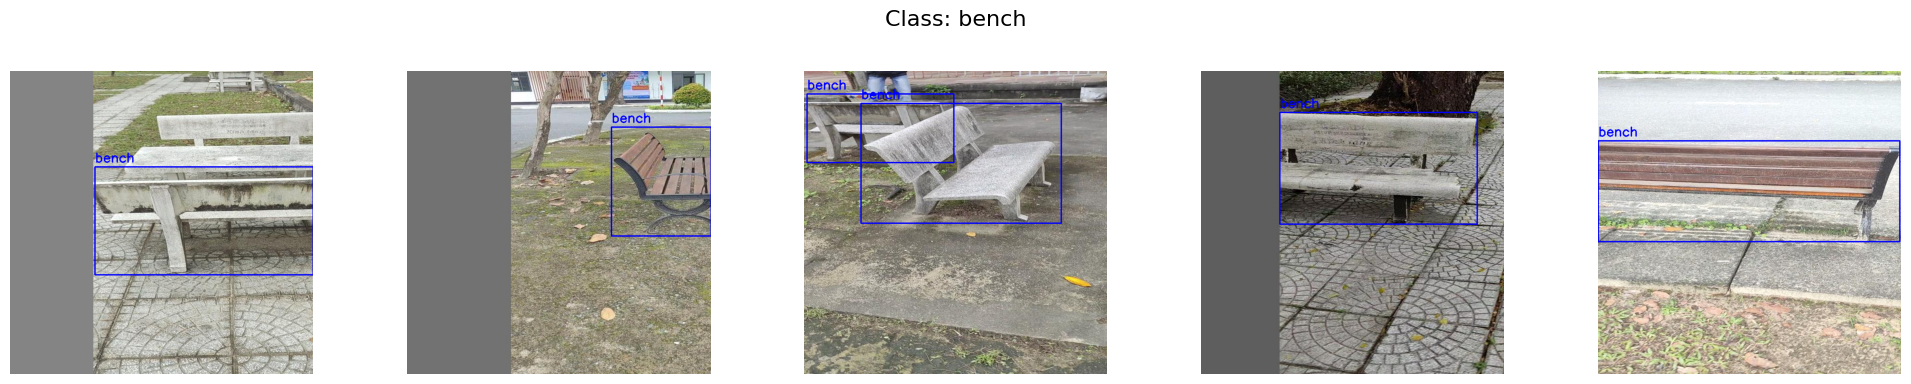

Visualizing samples for class: 'cone'


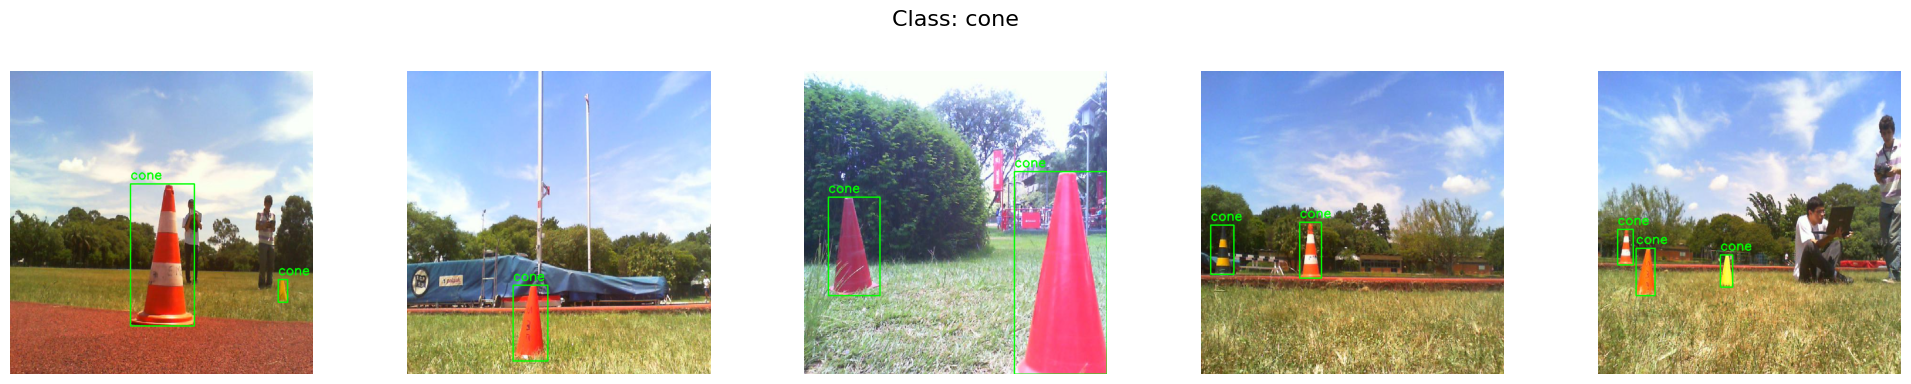

Visualizing samples for class: 'sign'


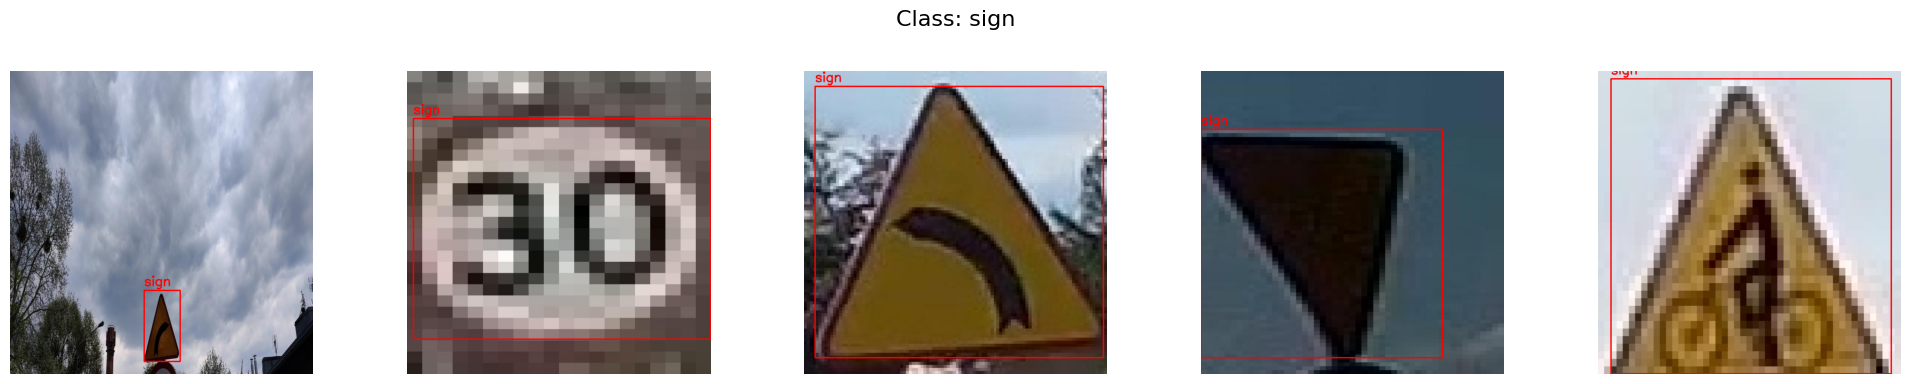

In [ ]:
%matplotlib inline

def visualize_dataset_samples(yaml_path, num_samples_per_class=5):
    """Visualize random samples from the detection dataset with bounding boxes.
    
    Args:
        yaml_path (str or Path): Path to the YAML file containing dataset configuration
        num_samples_per_class (int, optional): Number of samples to show per class. Defaults to 5.
    
    The function:
    1. Loads class names and paths from YAML
    2. Finds images containing each class
    3. Draws bounding boxes with class labels
    4. Creates a figure with samples from each class
    """
    # Load dataset configuration
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    
    class_names = data['names']
    train_image_dir = Path('../data/processed/detection/images/train')
    train_label_dir = Path('../data/processed/detection/labels/train')

    # Define distinct colors for visualization
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Blue, Green, Red
    
    # Process each class
    for class_id, class_name in enumerate(class_names):
        print(f"Visualizing samples for class: '{class_name}'")
        
        # Find label files containing current class
        class_specific_labels = []
        for lbl_path in train_label_dir.glob("*.txt"):
            with open(lbl_path, 'r') as f_in:
                for line in f_in:
                    if line.strip().startswith(str(class_id)):
                        class_specific_labels.append(lbl_path)
                        break
        
        if not class_specific_labels:
            print(f"  - No samples found for class '{class_name}'")
            continue
            
        # Select random samples
        sample_labels = random.sample(class_specific_labels, 
                                    min(num_samples_per_class, len(class_specific_labels)))
        
        # Create visualization figure
        plt.figure(figsize=(20, 4))
        plt.suptitle(f"Class: {class_name}", fontsize=16)
        
        # Process each sample
        for i, lbl_path in enumerate(sample_labels):
            # Find corresponding image file
            img_path = train_image_dir / f"{lbl_path.stem}.jpg"  # Try .jpg
            if not img_path.exists():
                img_path = train_image_dir / f"{lbl_path.stem}.png"  # Try .png
            if not img_path.exists():
                # Try any extension
                try:
                    img_path = next(train_image_dir.glob(f"{lbl_path.stem}.*"))
                except StopIteration:
                    print(f"  - Could not find image for label {lbl_path.name}")
                    continue

            # Load and verify image
            img = cv2.imread(str(img_path))
            if img is None:
                print(f"  - Failed to load image: {img_path}")
                continue
            h, w, _ = img.shape
            
            # Draw bounding boxes
            with open(lbl_path, 'r') as f_in:
                for line in f_in:
                    parts = line.strip().split()
                    c_id, cx, cy, bw, bh = [float(p) for p in parts]
                    
                    if int(c_id) != class_id:  # Skip other classes
                        continue
                    
                    # Convert normalized coordinates to pixel coordinates
                    x1 = int((cx - bw / 2) * w)
                    y1 = int((cy - bh / 2) * h)
                    x2 = int((cx + bw / 2) * w)
                    y2 = int((cy + bh / 2) * h)
                    
                    # Draw box and label
                    color = colors[int(c_id)]
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(img, class_names[int(c_id)], (x1, y1 - 10), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

            # Add to subplot
            ax = plt.subplot(1, num_samples_per_class, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
    
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Visualize dataset samples
visualize_dataset_samples(DATA_YAML_PATH)

## 3. Dataset Visualization

This section implements a visualization utility to verify:
1. Correct data loading
2. Proper bounding box annotations
3. Class distribution
4. Image quality and variety

The visualization samples random images from each class to ensure balanced representation and correct labeling.

In [ ]:
# Initialize YOLO model with pretrained weights
model = YOLO('yolo11m.pt') 

print("YOLO11m model loaded successfully.")
print(f"Training will use the dataset defined in: {DATA_YAML_PATH}")

YOLO11n model loaded successfully.
Training will use the dataset defined in: ../data/processed/detection/data.yaml


## 4. Model Setup

Initialize the YOLO model:
1. Load pretrained YOLOv11-medium weights
2. Configure for custom number of classes
3. Prepare for fine-tuning on peatland dataset

In [ ]:
# Execute training with defined configuration
results = model.train(
    data=str(DATA_YAML_PATH),       # Dataset configuration
    epochs=NUM_EPOCHS,              # Number of training epochs
    imgsz=IMAGE_SIZE,              # Input image size
    batch=BATCH_SIZE,              # Batch size for training
    project='metrics/detection',    # Project directory for outputs
    name='peatland_detector_v2',   # Run name for this training session
    device=DEVICE,                 # Training device (GPU/CPU)
)

print("\nTraining complete!")
print("Model and results saved in the 'metrics/detection/peatland_detector_v2' directory.")

New https://pypi.org/project/ultralytics/8.3.174 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.173 🚀 Python-3.11.8 torch-2.7.1 MPS (Apple M2 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/processed/detection/data.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=peatland_detector_v2, nbs=64, nms=False, opset=None, optimiz

train: Scanning /Users/stahlma/Desktop/01_Studium/09_Vision_Project/peatland_navigation/data/processed/detection/labels/train... 4881 images, 1 backgrounds, 0 corrupt: 100%|██████████| 4881/4881 [00:02<00:00, 1787.43it/s]

train: /Users/stahlma/Desktop/01_Studium/09_Vision_Project/peatland_navigation/data/processed/detection/images/train/cone_4_z8126b7d060d92d74599e0618_f103ee1115bfb3457_d20170226_m021720_c001_v0001038_t0047_png.rf.a7ef3f5e72c7f5cade50a29d8fdfc49c.jpg: 2 duplicate labels removed
train: /Users/stahlma/Desktop/01_Studium/09_Vision_Project/peatland_navigation/data/processed/detection/images/train/cone_4_z8126b7d060d92d74599e0618_f103ee1115bfb3493_d20170226_m021731_c001_v0001038_t0047_png.rf.8cf69b66f2acfc767afd0ceb952addc2.jpg: 1 duplicate labels removed
train: /Users/stahlma/Desktop/01_Studium/09_Vision_Project/peatland_navigation/data/processed/detection/images/train/cone_4_z8126b7d060d92d74599e0618_f103ee1115bfb3990_d20170226_m022155_c001_v0001038_t0047_png.rf.19b9dd55ee267ecf8beec79d42bad3ef.jpg: 1 duplicate labels removed
train: /Users/stahlma/Desktop/01_Studium/09_Vision_Project/peatland_navigation/data/processed/detection/images/train/cone_4_z8126b7d060d92d74599e0618_f103ee1115bfb3de

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 91.0±28.1 MB/s, size: 45.7 KB)


val: Scanning /Users/stahlma/Desktop/01_Studium/09_Vision_Project/peatland_navigation/data/processed/detection/labels/val... 610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 610/610 [00:00<00:00, 1076.73it/s]

val: /Users/stahlma/Desktop/01_Studium/09_Vision_Project/peatland_navigation/data/processed/detection/images/val/cone_4_z8126b7d060d92d74599e0618_f103ee1115bfb48c7_d20170226_m023419_c001_v0001038_t0047_png.rf.e9cdcd07afa2731df50fe92a342648e2.jpg: 1 duplicate labels removed
val: /Users/stahlma/Desktop/01_Studium/09_Vision_Project/peatland_navigation/data/processed/detection/images/val/cone_4_z8126b7d060d92d74599e0618_f103ee1115bfb6f31_d20170226_m030611_c001_v0001038_t0047_png.rf.ac34573f7d3d35fcce600a55798a0392.jpg: 1 duplicate labels removed
val: /Users/stahlma/Desktop/01_Studium/09_Vision_Project/peatland_navigation/data/processed/detection/images/val/cone_4_z8126b7d060d92d74599e0618_f110e5e48fac43ae0_d20170301_m024243_c001_v0001036_t0016_png.rf.297041a47600943992e0f64142bc9baa.jpg: 1 duplicate labels removed
val: /Users/stahlma/Desktop/01_Studium/09_Vision_Project/peatland_navigation/data/processed/detection/images/val/cone_4_z8126b7d060d92d74599e0618_f110e5e48fac43e95_d20170301_m025

Plotting labels to metrics/detection/peatland_detector_v2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to metrics/detection/peatland_detector_v2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      15.8G      1.116      1.343      1.541          8        640:  94%|█████████▍| 575/611 [15:26<00:58,  1.61s/it]  


KeyboardInterrupt: 

## 5. Model Training

Execute the training pipeline with:
1. Custom dataset configuration
2. Defined hyperparameters
3. Automatic metric logging
4. Model checkpointing

The training results and model weights will be saved in the metrics directory for future evaluation and deployment.